Import modules

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.fftpack as fft
from astropy.io import fits
from scipy import optimize
from poppy import zernike
from scipy import signal
import os
import pytz
import time
import re

In [2]:
from matplotlib import rc
from matplotlib import rcParams
rc('xtick', labelsize=15) 
rc('ytick', labelsize=15)

rc('axes', labelsize=20) 
rc('axes', linewidth=2)

rcParams['axes.titlesize'] = 15
rcParams['legend.fontsize'] = 15
rcParams['patch.linewidth'] = 1
#rcParams['axes.titlepad'] = 30
rcParams['axes.labelpad'] = 10

variables

In [3]:
outD = 7.77010            # primary diameter (m)
inD = 1.024               # inner M2 diameter (m)
n = 48                    # number sample points across the screen (Not the number of subapertures)
nacross = 43              # number of subapertures across the aperture
pscale = outD/(nacross)   # pixel size (m) of samples in pupil plane

make aperture

In [4]:
#  Aperture containing zeros
x = np.linspace(-(n)/2,(n)/2,n)*pscale 
y = np.linspace(-(n)/2,(n)/2,n)*pscale
mg = np.meshgrid(x,y)
ar = np.sqrt(np.sum((m**2 for m in mg)))
ap_outer = (ar <= (7.3)/2)
ap_inner = (ar <= 1.5/2)   
ap = (ap_outer ^ ap_inner).astype(int)

#  Aperture containing nans
ap_nan = np.copy(ap.astype(np.float))  
ap_nan[np.where(ap==0)] = np.nan

make frequency grid

In [24]:
kx = fft.fftshift(fft.fftfreq(n,pscale))
ky = fft.fftshift(fft.fftfreq(n,pscale))
mg = np.meshgrid(kx,ky)
kr = np.sqrt(np.sum((m**2 for m in mg))) 

directory paths

In [5]:
dome_seeing = "/Users/melisatallis/Documents/Research/GPIDomeSeeing/data/aotelem/aored_When_2016.2.27_1.35.6_poldm_phase.fits"

In [6]:
clean_seeing = "/Users/melisatallis/Documents/Research/GPIDomeSeeing/data/aotelem/aored_When_2016.9.19_2.25.7_poldm_phase.fits"

In [7]:
save_path = "/Users/melisatallis/Documents/Research/GPIDomeSeeing/data/Results/individual_analysis/"
dstr = time.strftime('%Y%m%d')

lpdir = '/Users/melisatallis/Documents/Research/GPIDomeSeeing/data/aotelem/aored_When_2016.2.27_0.40.14_poldm_phase.fits'
save_path = "/Users/melisatallis/Documents/Research/GPIDomeSeeing/data/aotelem/Results"
dstr = time.strftime('%Y%m%d')

functions

In [227]:
def radialProfile(image, center=None):
    """
    Calculate the avearge radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    ## Calculate the indices from the image
    y,x = np.indices((image.shape)) # first determine radii of all pixels
    
    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])
     
    r = np.hypot(x - center[0], y - center[1]).astype(np.int) 
    
    n = np.bincount(r.ravel())
    sy = np.bincount(r.ravel(), image.ravel())
    mean = sy/n
    
    return mean

def implot(image, display=True, **kwargs):
    """Plot an image with colorbar.
    
    image - The 2d image
    kwargs - settings for curstomizing plot"""

    ## Create matplotlib figure 
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    cax = ax.imshow(image, cmap = plt.cm.viridis, origin='lower', interpolation='none')
    cbar = fig.colorbar(cax, orientation='vertical')

    ## Modify plot based on keyword arguments
    if 'title' in kwargs: ax.set_title(kwargs['title'], fontsize=15)
    if 'xlabel' in kwargs: ax.set_xlabel(kwargs['xlabel'], fontsize=15)
    if 'ylabel' in kwargs: ax.set_ylabel(kwargs['ylabel'], fontsize=15)
    if 'cbar_label' in kwargs: cbar.set_label(kwargs['cbar_label'], 
                                              fontsize=15)
    if 'save_image' in kwargs: plt.savefig(kwargs['save_image'])

    if display: plt.show()
        
def PSDplot(ax, psd, f, low_bound, up_bound,lab,display=False, **kwargs):

    def func(x, a, b):
        return a+(b*x) 
    
    par,pcov = optimize.curve_fit(func,np.log10(freq[(freq > low_bound) & (freq < up_bound)]), np.log10(psd[(freq > low_bound) & (freq < up_bound)]), p0=(1, -3.5))
    slope = par[0]
    intercept = par[1]
    
    ## Plot original PSD and linear fit
    img = ax.loglog(freq,psd,'o',label = [lab, 'slope = {0:.2f}, int={1:.2f}'.format(slope, intercept)])
                    #(freq[(freq > low_bound) & (freq < up_bound)]),
                    #10**(func(np.log10(freq[(freq > low_bound) & (freq < up_bound)]),*par)), 'k')

    #ax.legend(['PSD', 'slope = {0:.2f}, intercept={1:.2f}'.format(slope, intercept)],loc=3, fontsize=15)
    ax.minorticks_on()
    ax.grid(b=True, which='major', color='black', linestyle='-')
    #ax.set_ylabel(r'$\mathrm{{PSD}} \,\, [\mu\mathrm{{m}}^2/\mathrm{{1/m}}]$', fontsize=24)
    #ax.set_xlabel(r'$f$ $\mathrm{[1/m]}$')
    #ax.set_title(whenstr, fontsize=30, y=1.04)
    ax.set_ylabel('PSD')
    ax.set_xlabel('Frequency [1/m]',fontsize=15)
    
    ## Modify plot based on keyword arguments
    if 'title' in kwargs: ax.set_title(kwargs['title'], fontsize=10)
    if 'xlabel' in kwargs: ax.set_xlabel(kwargs['xlabel'], fontsize=15)
    if 'ylabel' in kwargs: ax.set_ylabel(kwargs['ylabel'], fontsize=15)
    if display: plt.show()
    
    #filename = "{0}_PSD{1}.png".format(filebase, whenstr)
    #plt.savefig(filename)
    #plt.close(fig)

    return slope, intercept
    

calculate sp psd

In [21]:
def make_sp_psd(filename):
    hdulist = fits.open(filename,memmap=True)
    phase = hdulist[0].data.astype('float')
    timesteps, phx, phy = phase.shape            # contains a datacube
    avg_phase = np.nanmean(phase*ap_nan,axis=0)  # used to find average zernikes 
    
    # remove zernikes form cube
    z_basis = zernike.zernike_basis_faster(nterms= 6, npix = 48)
    z_coeff = zernike.opd_expand_nonorthonormal(avg_phase, aperture=ap, nterms=6)
    thin_lens = np.sum(z_coeff[:,None,None]*z_basis[:,:,:],axis=0)

    c_phase = (phase - thin_lens[None,:,:])*ap_nan
    c_phase[np.isnan(c_phase)]=0.
    
    # computer fourier transform of cube
    phFT = np.zeros((timesteps,phx,phy), dtype=complex)
    for t in np.arange(timesteps):
        phFT[t,:,:] = fft.fftshift(fft.fft2(c_phase[t,:,:]))/ap.sum()
    print('Done with FT')
    
    # compute 2d psd cube
    psd2D = np.zeros((timesteps, phx, phy),dtype=float)
    for k in np.arange(phx):
        for l in np.arange(phy):
            psd2D[:,k,l] = np.abs(phFT[:,k,l])**2
    avg_psd2D = np.mean(psd2D, axis=0)
    print('Done with PSD')    
    
    # compute radial average of 2d psd cube and frequency
    avg_psd1D =  radialProfile(avg_psd2D)
    return avg_psd1D

In [25]:
freq1 = radialProfile(kr)

In [22]:
psd1D_weak_seeing = make_sp_psd(clean_seeing)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


Done with FT
Done with PSD


In [23]:
psd1D_strong_seeing = make_sp_psd(dome_seeing)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


Done with FT
Done with PSD


<IPython.core.display.Javascript object>


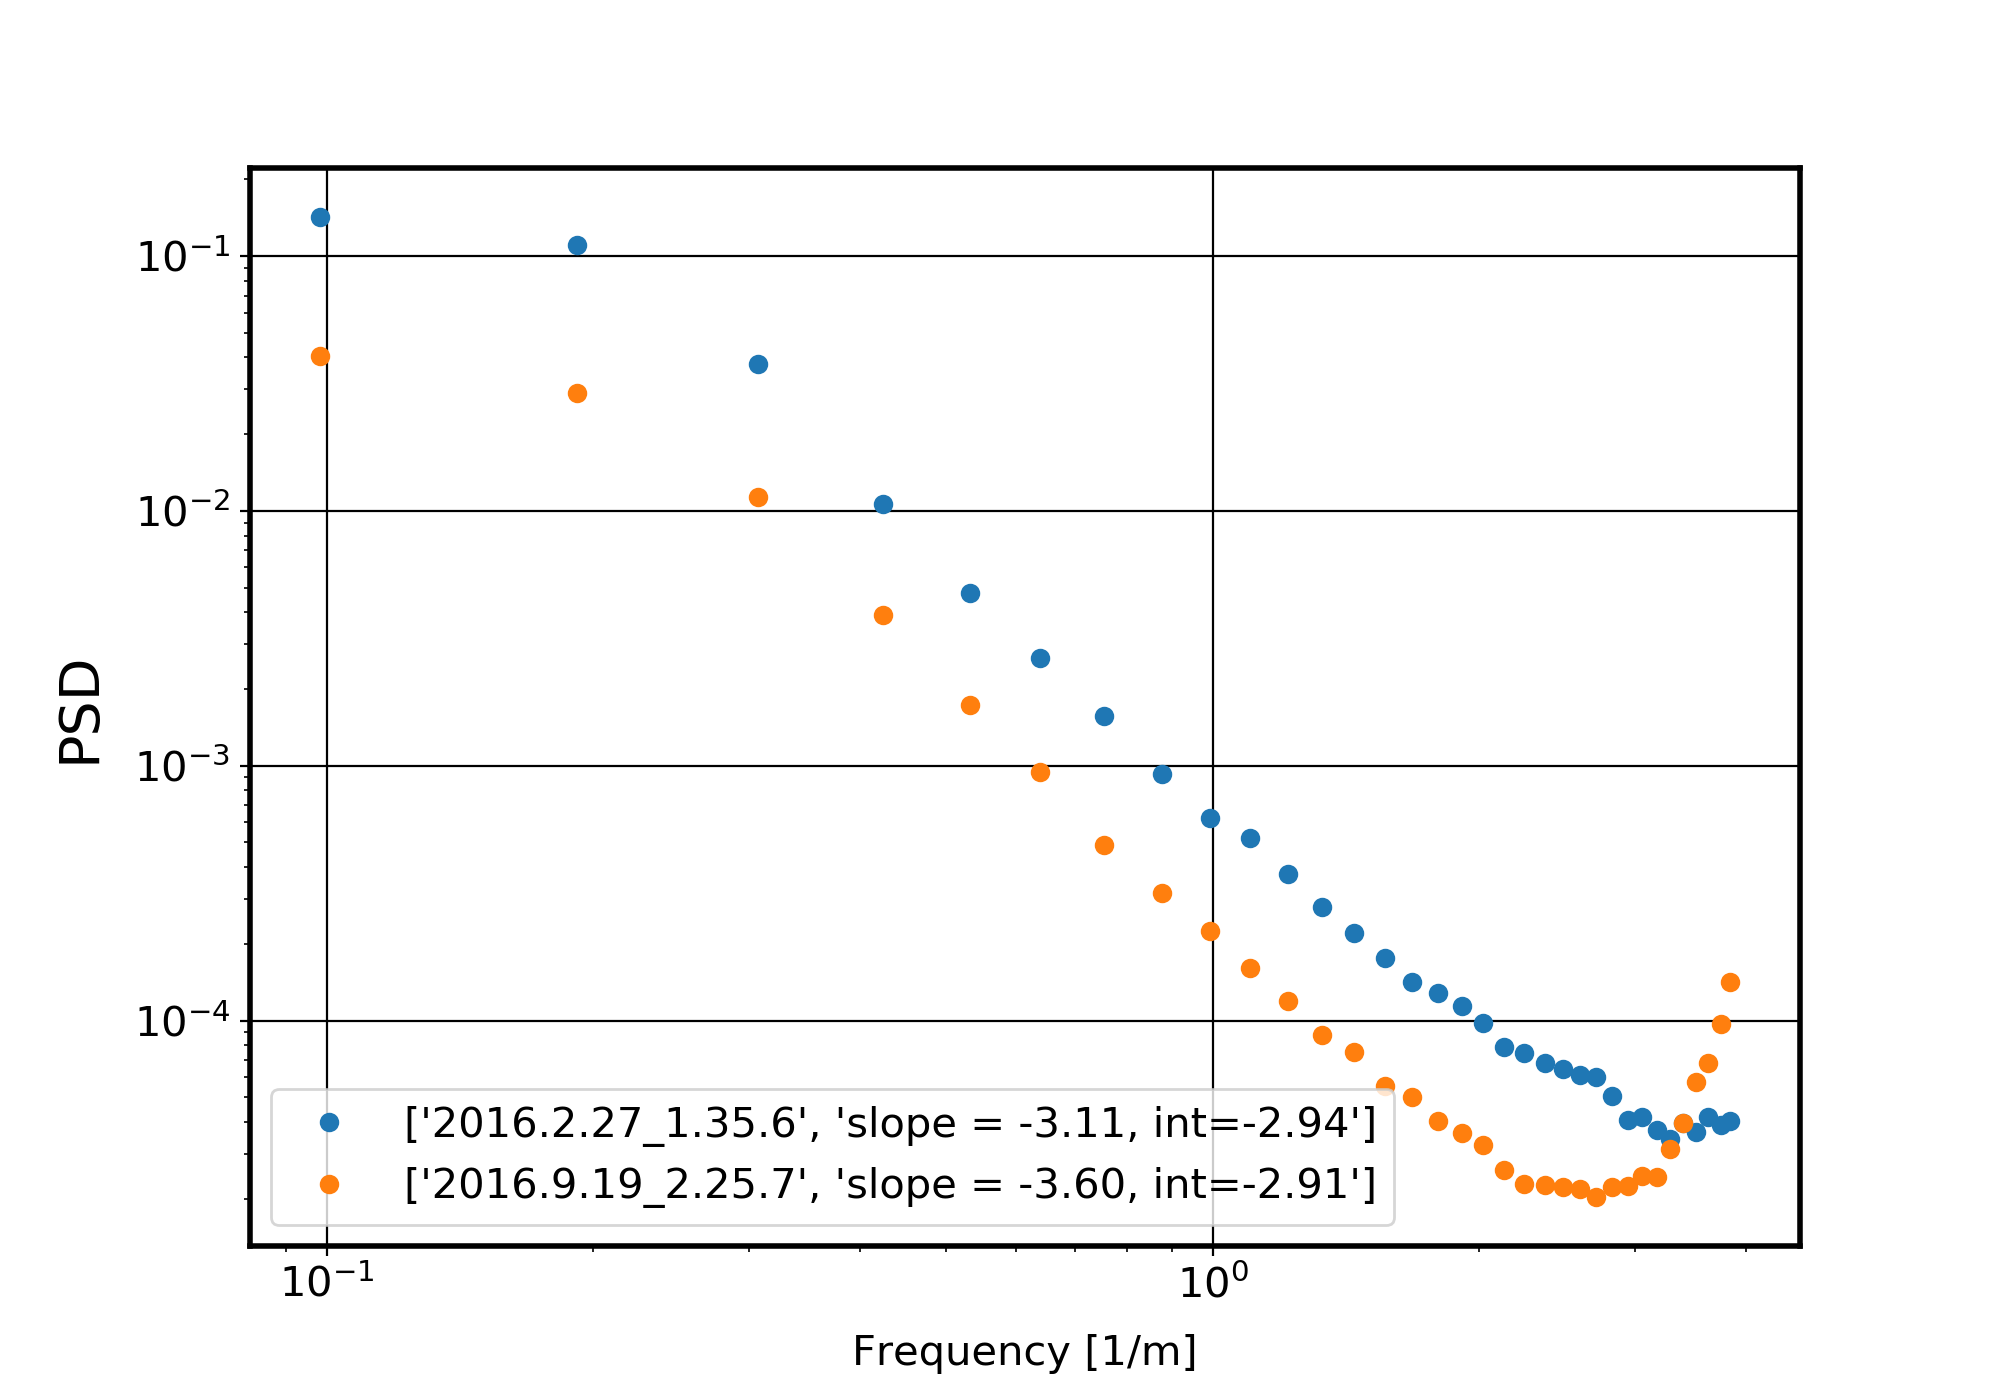

In [228]:
%matplotlib notebook

fig,ax1 = plt.subplots(1,1,figsize = [10,7])
slope1, intercept1 = PSDplot(ax1,psd1D_strong_seeing, freq1, low_bound = 1/(pscale*nacross), up_bound = 1/(2*pscale), lab = '2016.2.27_1.35.6')
slope, intercept = PSDplot(ax1,psd1D_weak_seeing, freq1, low_bound = 1/(pscale*nacross), up_bound = 1/(2*pscale), lab = '2016.9.19_2.25.7')
ax1.legend(loc = 3)
#plt.savefig(save_path+'sp_psd_'+dstr+'.png')

In [226]:
intercept1

-2.9439078593494283

In [224]:
intercept

4.375334987892325

<IPython.core.display.Javascript object>


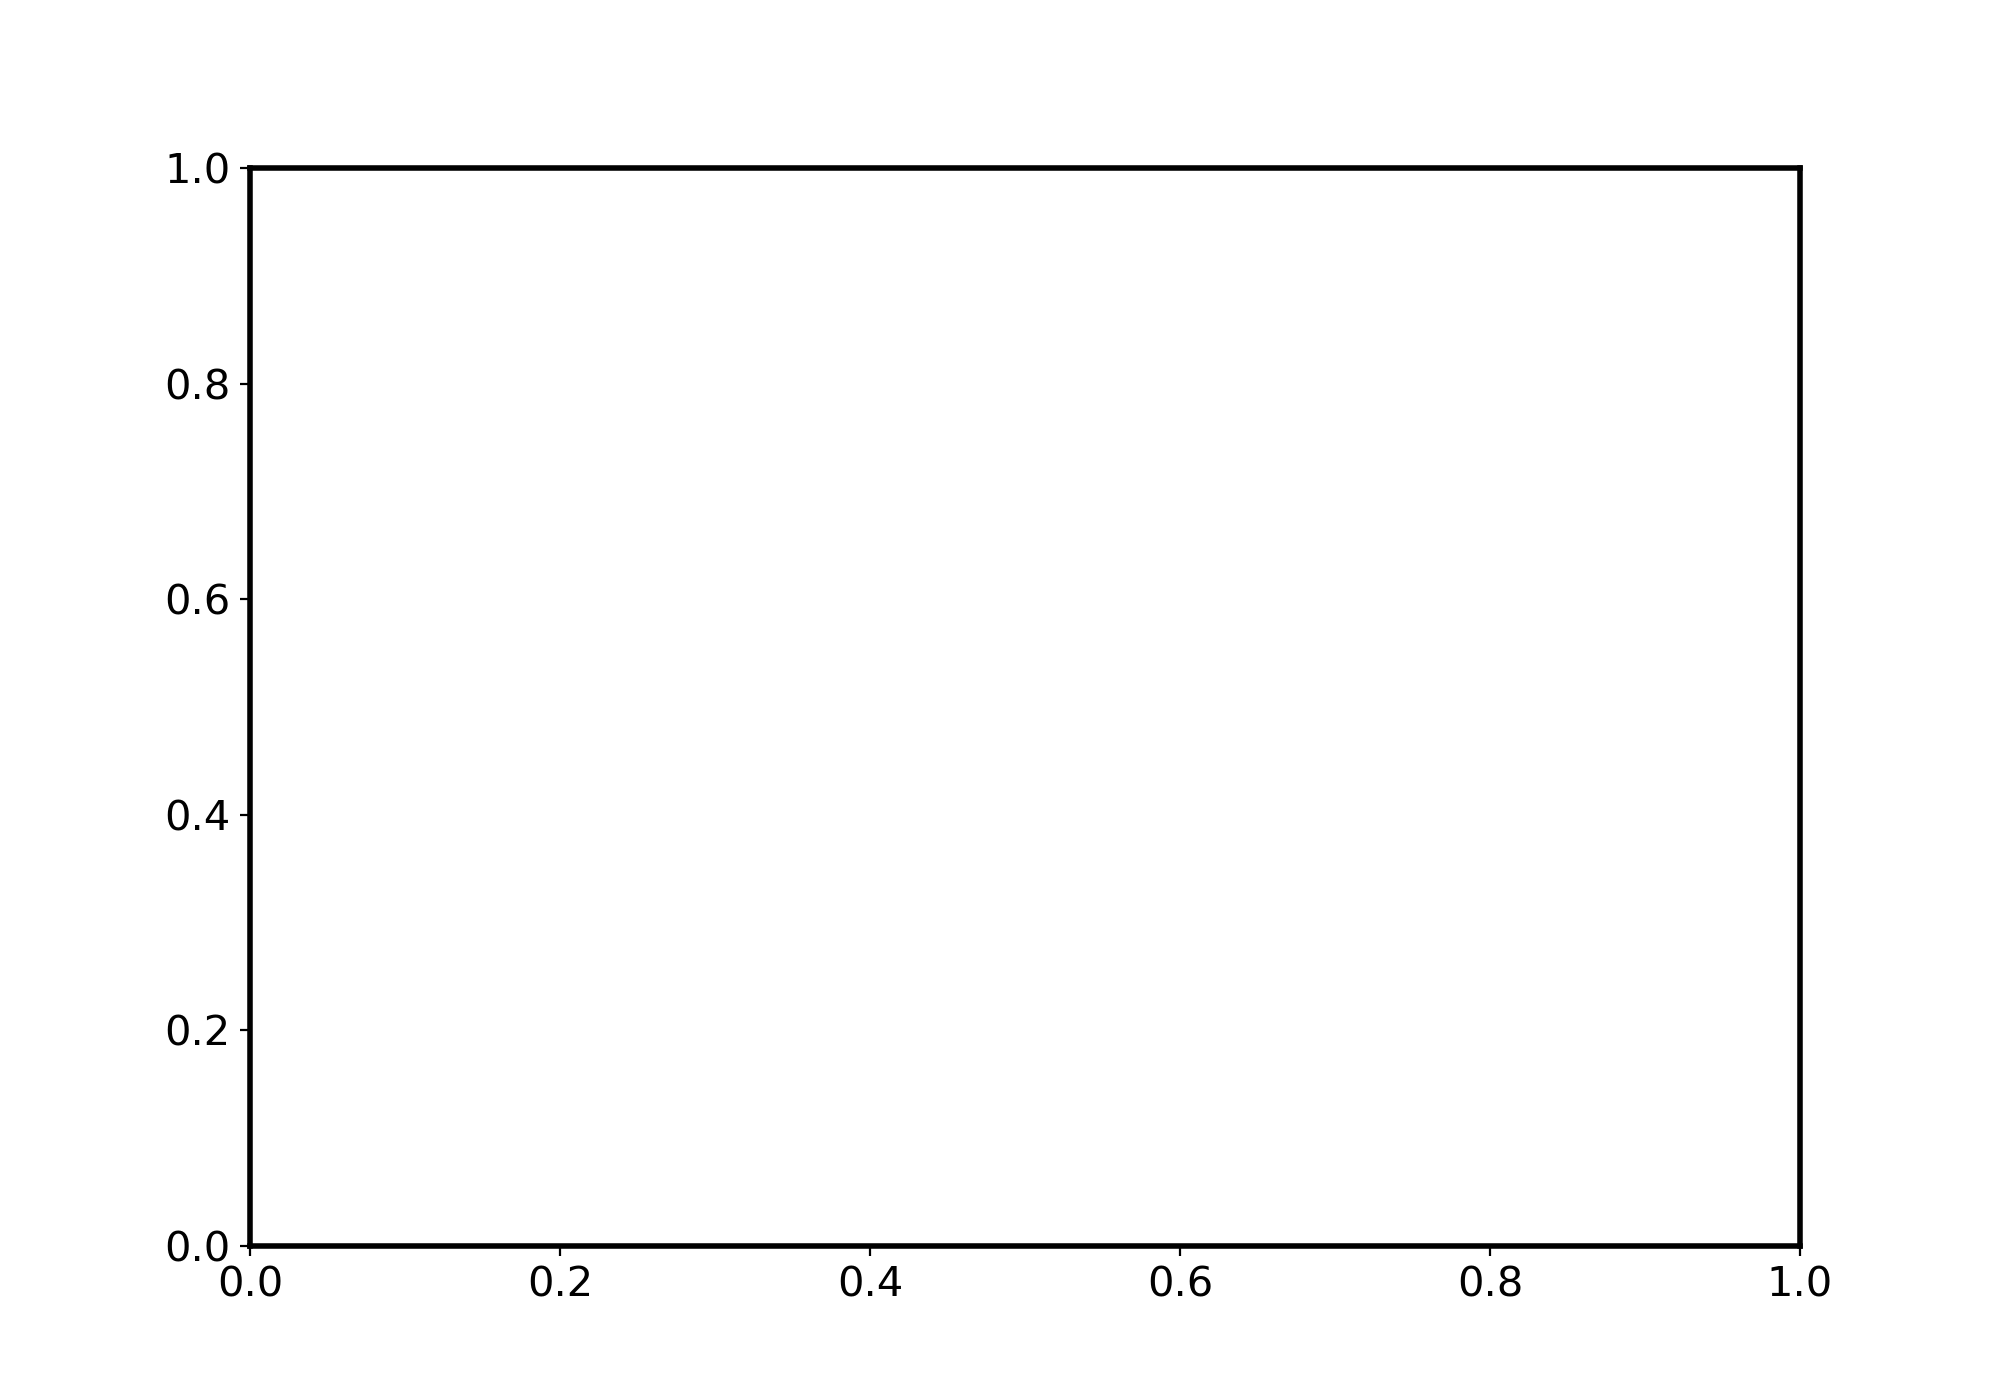

IndexError: boolean index did not match indexed array along dimension 0; dimension is 21907 but corresponding boolean dimension is 34

In [208]:
fig,ax1 = plt.subplots(1,1,figsize = [10,7])
slope, intercept = PSDplot(ax1,t_psd1D_weak_seeing, freq2, low_bound = 1/(1), up_bound = 1/(.1), lab = 'weak dome seeing', display=True)
slope1, intercept1 = PSDplot(ax1,t_psd1D_strong_seeing, freq3, low_bound = 1/(1), up_bound = 1/(.1), lab = 'strong dome seeing', display=True)
#ax1.legend(loc = 3)
plt.savefig(save_path+'t_psd_'+dstr+'.png')

In [119]:
hdulist = fits.open(clean_seeing,memmap=True)
phase = hdulist[0].data.astype('float')
timesteps, phx, phy = phase.shape            # contains a datacube
avg_phase = np.nanmean(phase*ap_nan,axis=0)  # used to find average zernikes 
    
# remove zernikes form cube
z_basis = zernike.zernike_basis_faster(nterms= 6, npix = 48)
z_coeff = zernike.opd_expand_nonorthonormal(avg_phase, aperture=ap, nterms=6)
thin_lens = np.sum(z_coeff[:,None,None]*z_basis[:,:,:],axis=0)

c_phase = (phase - thin_lens[None,:,:])*ap_nan
c_phase[np.isnan(c_phase)]=0.
print('Done removing zernikes')

/Users/MelisaT/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


Done removing zernikes


<IPython.core.display.Javascript object>


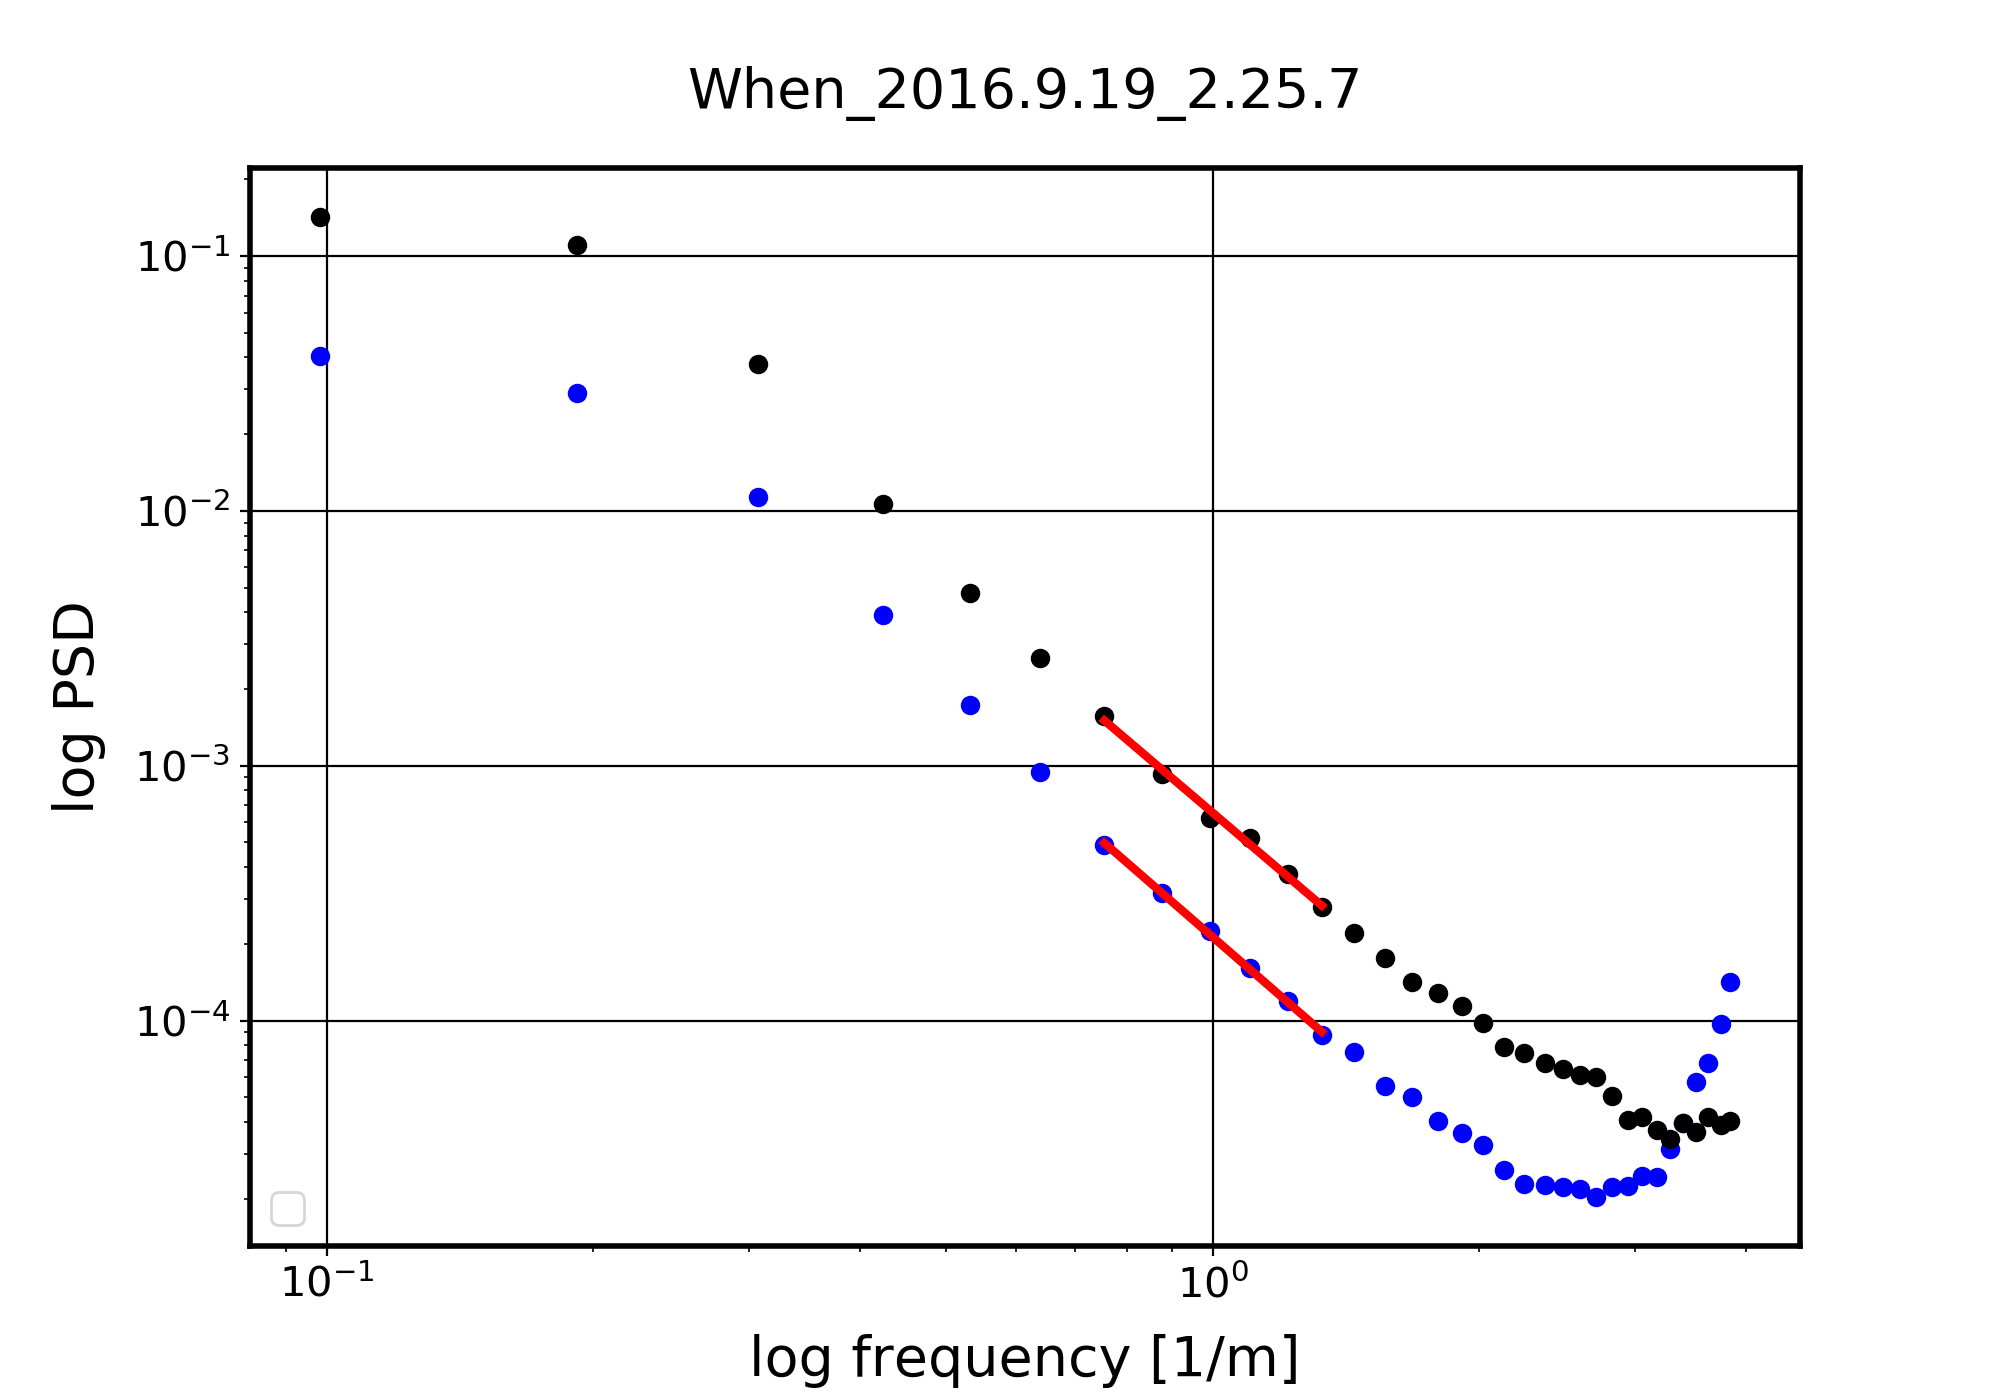

-3.6718313217062146
-3.184047038375305


/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:938: UserWarning: Legend does not support 'strong' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:938: UserWarning: Legend does not support 'slope = -3.18, intercept=-2.96' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)


Text(0.5,0,'log frequency [1/m]')

In [120]:
%matplotlib notebook

low_bound = 5/(nacross*pscale)
up_bound = 1/(4*pscale)
#whenstr = df.loc[n,'whenstr']
    
# Plotting PSD
fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)

def func(x, a, b):
    return a+(b*x) 
    
par,pcov = optimize.curve_fit(func,np.log10(freq1[(freq1 > low_bound) & (freq1 < up_bound)]),
                                np.log10(psd1D_weak_seeing[(freq1 > low_bound) & (freq1 < up_bound)]), p0=(1, -3.5))
slope = par[0]
intercept = par[1]

print(slope)
    
## Plot original PSD and linear fit
ax.loglog(freq1, psd1D_weak_seeing,'bo',(freq1[(freq1 > low_bound) & (freq1 < up_bound)]),
                10**(func(np.log10(freq1[(freq1 > low_bound) & (freq1 < up_bound)]),*par)), 'r',lw=3)

par,pcov = optimize.curve_fit(func,np.log10(freq1[(freq1 > low_bound) & (freq1 < up_bound)]),
                                np.log10(psd1D_strong_seeing[(freq1 > low_bound) & (freq1 < up_bound)]), p0=(1, -3.5))
slope = par[0]
intercept = par[1]
    
## Plot original PSD and linear fit
ax.loglog(freq1, psd1D_strong_seeing,'ko',(freq1[(freq1 > low_bound) & (freq1 < up_bound)]),
                10**(func(np.log10(freq1[(freq1 > low_bound) & (freq1 < up_bound)]),*par)), 'r',lw=3)
print(slope)

ax.legend(['strong','slope = {0:.2f}, intercept={1:.2f}'.format(slope, intercept)],loc=3, fontsize=15)
ax.minorticks_on()
ax.grid(b=True, which='major', color='black', linestyle='-') 
ax.set_title('When_2016.9.19_2.25.7', fontsize=20, y=1.04)
ax.set_ylabel('log PSD')
ax.set_xlabel('log frequency [1/m]')

#plt.savefig(save_path+'weak_seeing_sp_PSD_'+dstr+'.png')

# Compute the ratio high freq power to low frequency power

In [43]:
freq

array([0.0984082 , 0.1916817 , 0.30654005, 0.42415536, 0.53175833,
       0.63880963, 0.75469508, 0.87731432, 0.99211101, 1.10195115,
       1.21740912, 1.32810173, 1.44541081, 1.56510916, 1.67941613,
       1.79792034, 1.91110509, 2.02172505, 2.13046928, 2.24837583,
       2.37183268, 2.48822689, 2.59880538, 2.7095923 , 2.82244958,
       2.94321357, 3.0554664 , 3.16974744, 3.28156776, 3.39862216,
       3.5135757 , 3.62613303, 3.75143407, 3.83206275])

In [69]:
from scipy import integrate

low_area = integrate.simps(x = freq[(freq > low_bound) & (freq <= .5)], y = avg_psd1D[(freq > low_bound) & (freq <= .5)])
print(low_area)
high_area = integrate.simps(x = freq[(freq > .5) & (freq < up_bound)], y = avg_psd1D[(freq > .5) & (freq < up_bound)])
print(high_area)
ratio = high_area/low_area
print(ratio)


0.00301479043075
0.00040039503276
0.13281023738


In [70]:
np.sqrt(np.sum(psd2D))

141.28771401188612

# Time analysis

Std of phase over time

<IPython.core.display.Javascript object>


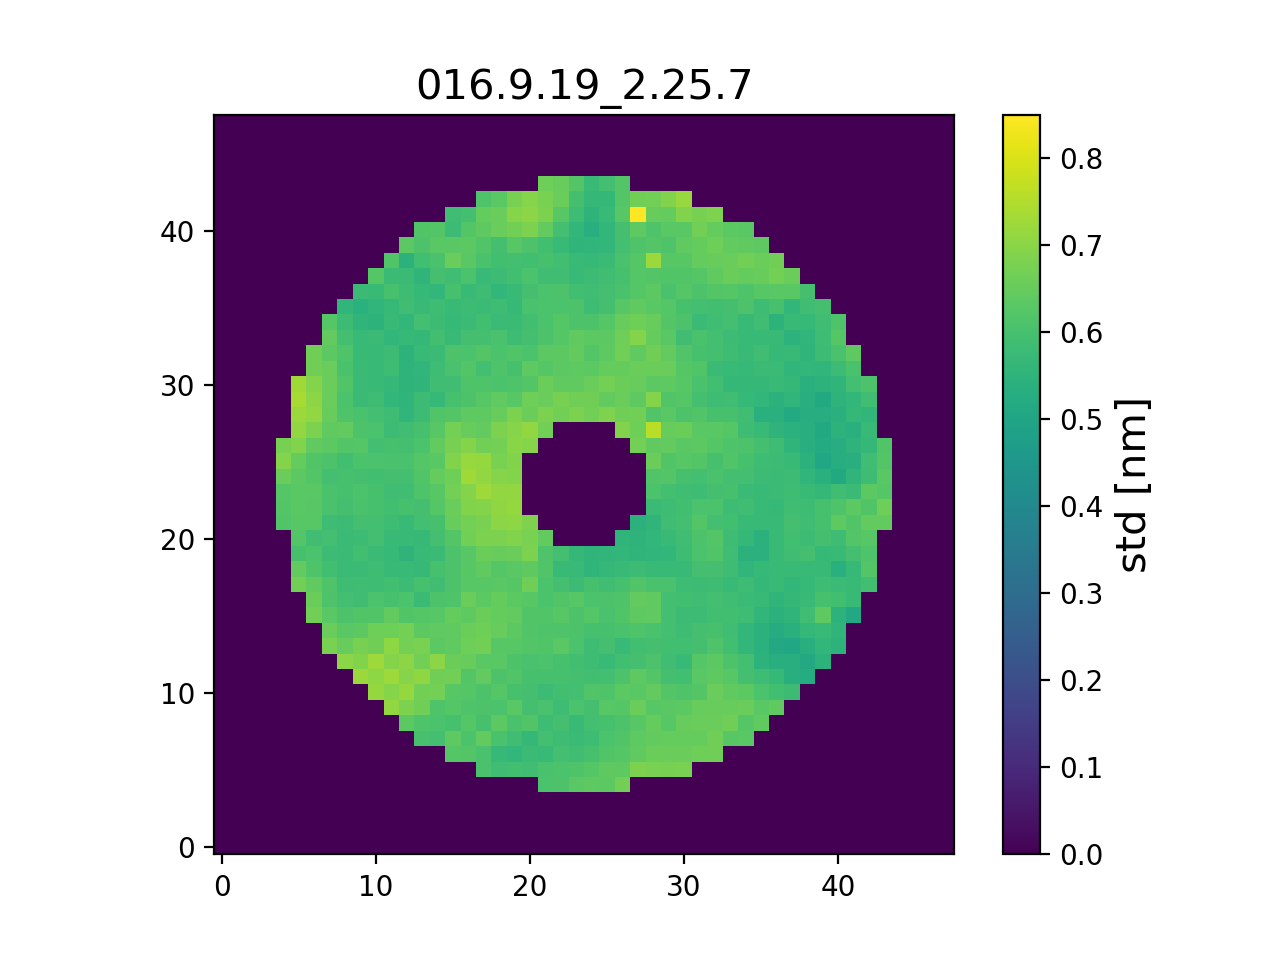

In [87]:
implot(np.std(c_phase,axis=0),cbar_label = 'std [nm]',title = '016.9.19_2.25.7')
#plt.savefig(save_path+'std_of_actuators_'+dstr+'.png')

<IPython.core.display.Javascript object>


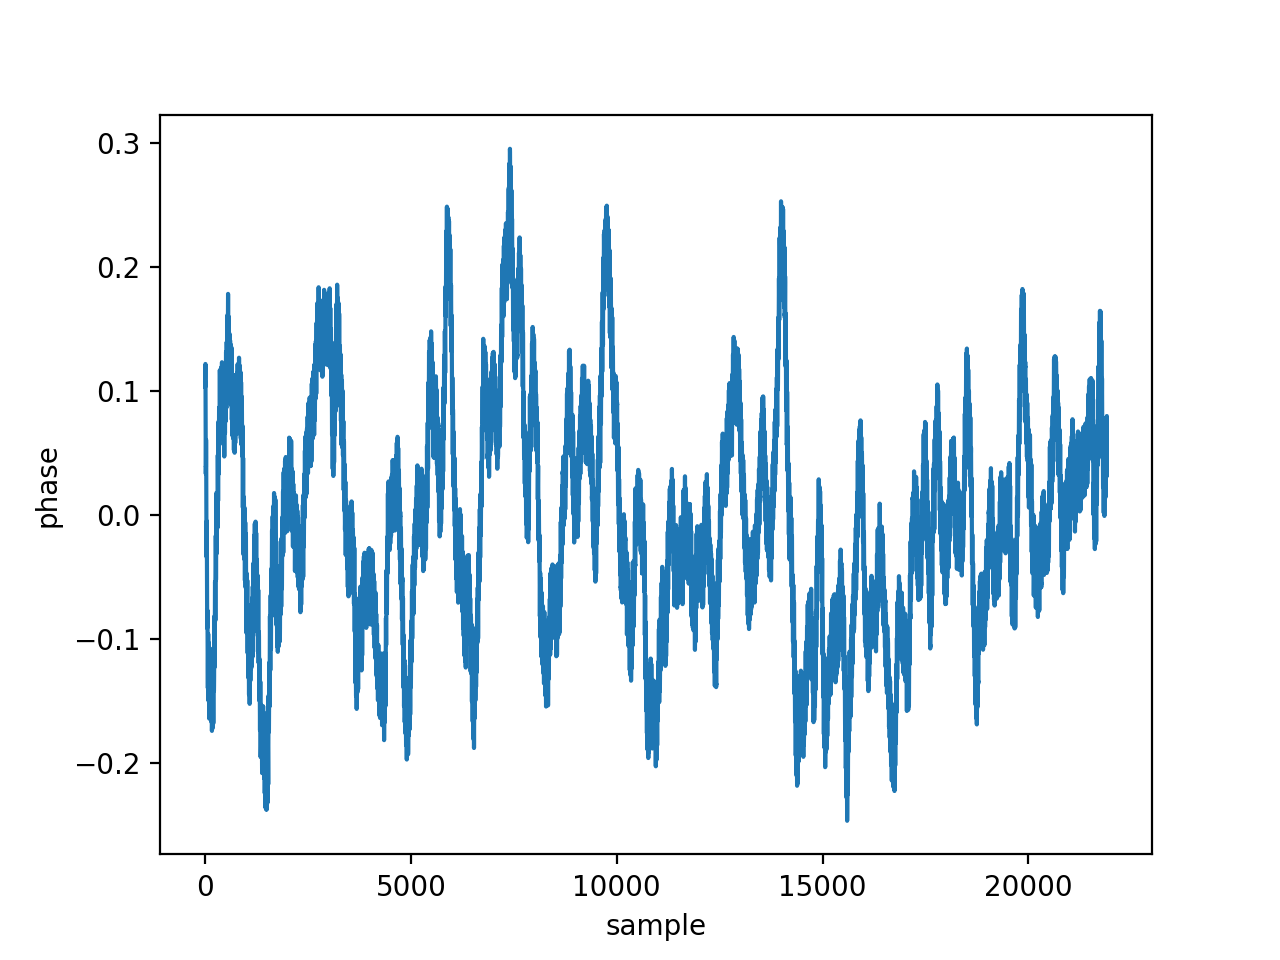

Text(0,0.5,'phase')

In [88]:
%matplotlib notebook

plt.plot(np.arange(timesteps),np.mean(c_phase,axis=(1,2)))
plt.xlabel('sample')
plt.ylabel('phase')

<IPython.core.display.Javascript object>


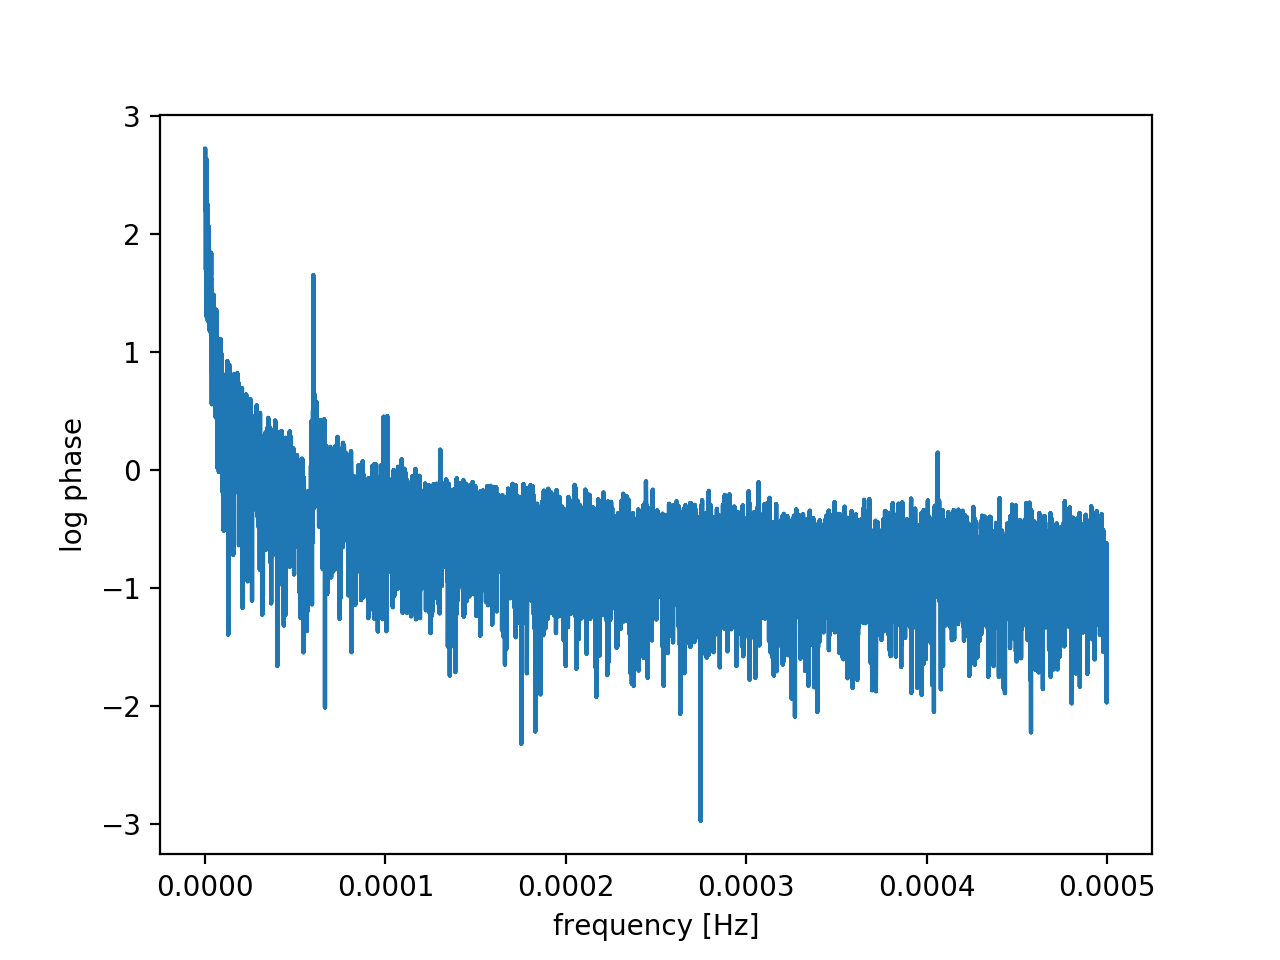

In [100]:
from scipy import signal

%matplotlib notebook

ft = np.abs(fft.fftfreq(timesteps,1000))
w = signal.blackman(timesteps)
avg_c_phase = np.mean(c_phase,axis=(1,2))
w_fft = np.abs(fft.fft(avg_c_phase*w))
plt.plot(ft,np.log10(w_fft))

plt.xlabel('frequency [Hz]')
plt.ylabel('log phase')

plt.savefig(save_path+'strong_seeing_FT_'+dstr+'.png')

In [49]:
def make_t_psd(filename):
    hdulist = fits.open(filename,memmap=True)
    phase = hdulist[0].data.astype('float')
    timesteps, phx, phy = phase.shape            # contains a datacube
    avg_phase = np.nanmean(phase*ap_nan,axis=0)  # used to find average zernikes 
    
    # remove zernikes form cube
    z_basis = zernike.zernike_basis_faster(nterms= 6, npix = 48)
    z_coeff = zernike.opd_expand_nonorthonormal(avg_phase, aperture=ap, nterms=6)
    thin_lens = np.sum(z_coeff[:,None,None]*z_basis[:,:,:],axis=0)

    c_phase = (phase - thin_lens[None,:,:])*ap_nan
    c_phase[np.isnan(c_phase)]=0.
    
    #calculate temporal FT
    ft = np.abs(fft.fftfreq(timesteps,.001))
    w = signal.blackman(timesteps)
    avg_c_phase = np.mean(c_phase,axis=(1,2))
    w_fft = np.abs(fft.fft(avg_c_phase*w))
    t_psd1D = np.abs(w_fft)**2
    
    return ft, t_psd1D

In [50]:
freq2, t_psd1D_weak_seeing = make_t_psd(clean_seeing)
freq3, t_psd1D_strong_seeing = make_t_psd(dome_seeing)



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


-3.154614279491019
4.056615447415986


<IPython.core.display.Javascript object>


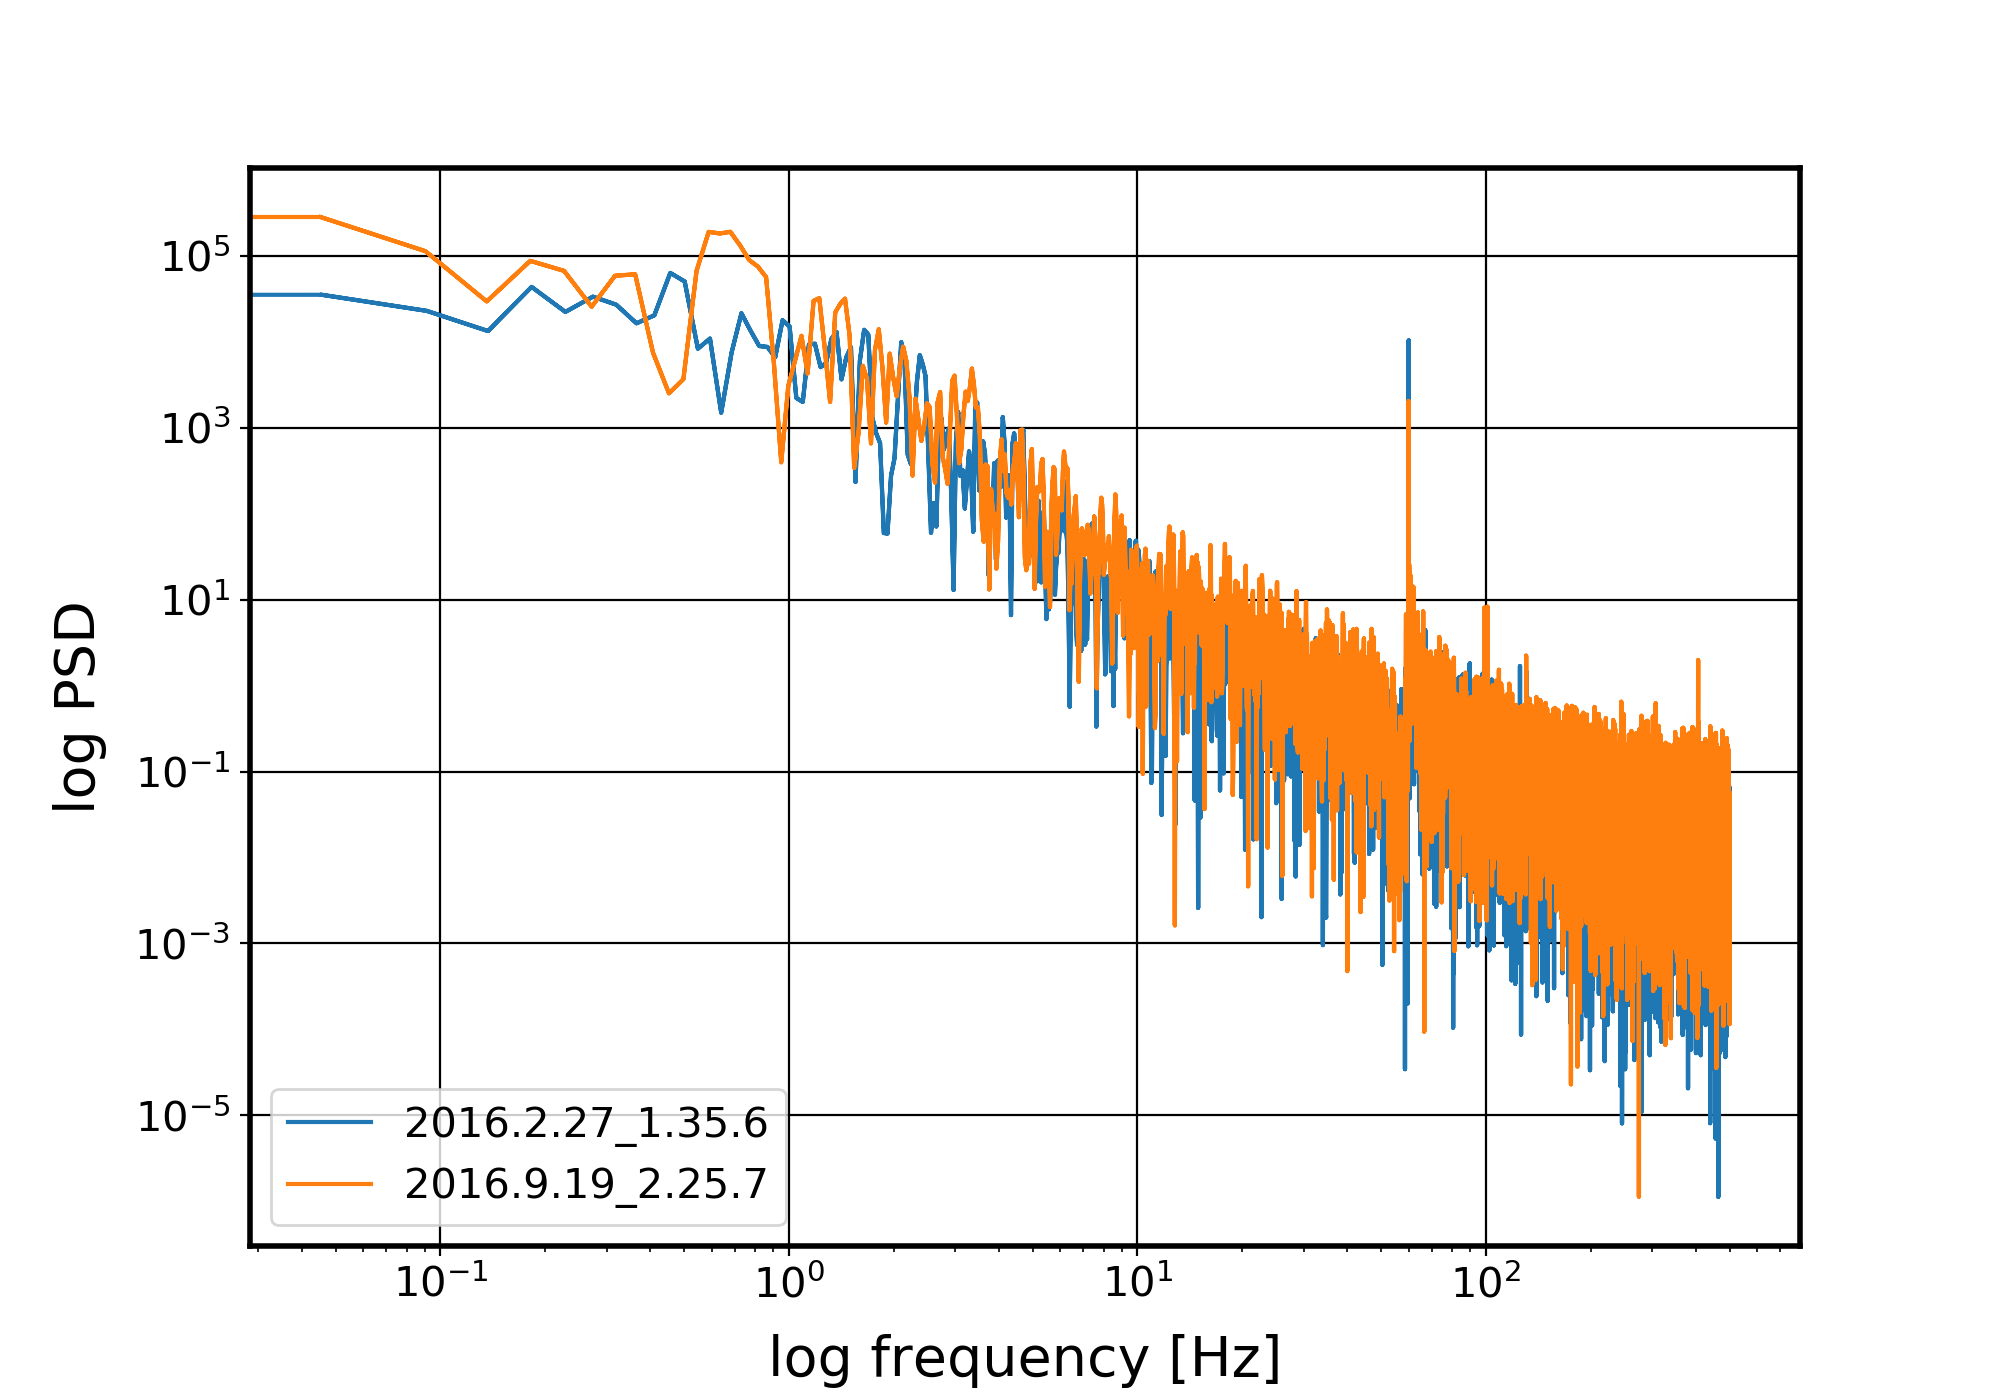

-3.2181994554410065
4.375334987892325


In [223]:
low_bound = 1/(1)
up_bound = 1/(.1)

def func(x, a, b):
    return a+(b*x) 
    
par,pcov = optimize.curve_fit(func,np.log10(freq2[(freq2 > low_bound) & (freq2 < up_bound)]),
                              np.log10(t_psd1D_weak_seeing[(freq2 > low_bound) & (freq2 < up_bound)]), p0=(1, -3.5))
slope = par[1]
intercept = par[0]

print(slope)
print(intercept)

    
plt.figure(figsize=[10,7])
## Plot original PSD and linear fit
plt.loglog(freq2, t_psd1D_weak_seeing,label = '2016.2.27_1.35.6')


low_bound = 1/(1)
up_bound = 1/(.1)

par,pcov = optimize.curve_fit(func,np.log10(freq3[(freq3 > low_bound) & (freq3 < up_bound)]),
                              np.log10(t_psd1D_strong_seeing[(freq3 > low_bound) & (freq3 < up_bound)]), p0=(1, -3.5))
slope = par[1]
intercept = par[0]

print(slope)
print(intercept)

## Plot original PSD and linear fit
plt.loglog(freq3, t_psd1D_strong_seeing, label = '2016.9.19_2.25.7')

#plt.loglog(ft,np.abs(w_fft)**2)

plt.xlabel('log frequency [Hz]')
plt.ylabel('log PSD')
plt.legend(loc = 3)
plt.minorticks_on()
plt.grid(b=True, which='major', color='black', linestyle='-') 
#ax.set_title(whenstr, fontsize=30, y=1.04)
plt.savefig(save_path+'t_PSD_'+dstr+'.png')